In [ ]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import pandas as pd
import scipy.io

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile


In [ ]:
import shutil
shutil.copyfile("/content/drive/MyDrive/Bitirme/data.npy","/content/data.npy",)
shutil.copyfile("/content/drive/MyDrive/Bitirme/data_y.npy","/content/data_y.npy",)

'/content/data_y.npy'

In [ ]:
data = np.load('/content/data.npy')
data_y = np.load('/content/data_y.npy')

In [ ]:
data=data.reshape(1026,80,80)
data_y=data_y.reshape(1026,80,80)

In [ ]:
image_dataset=data
mask_dataset=data_y

In [ ]:
test_dataset=image_dataset[800:1026]
test_mask_dataset=mask_dataset[800:1026]

In [ ]:
image_dataset=image_dataset[:800]
mask_dataset=mask_dataset[:800]

In [ ]:
mask_dataset.shape

(800, 80, 80)

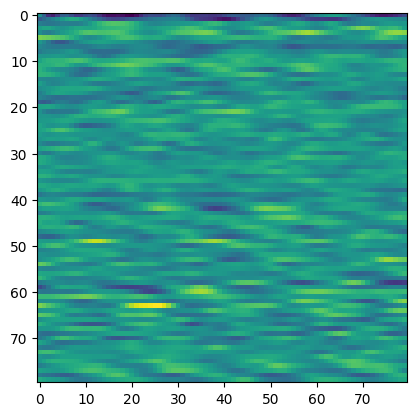

In [ ]:
plt.imshow(mask_dataset[1])

In [ ]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (800, 80, 80)
Mask data shape is:  (800, 80, 80)
Max pixel value in image is:  283.57459810075176
Labels in the mask are :  [-121.14302883 -120.25849718 -120.01650525 ...   96.8267962    96.96643032
   97.11078802]


In [ ]:
def scaler(data):
  scaler = MinMaxScaler()
  count=0
  for i in data:
    scaled_data = scaler.fit_transform(i)
    data[count]=scaled_data
    count+=1
  count=0


In [ ]:
for i in (image_dataset,mask_dataset):
  scaler(i)

In [ ]:
  scaler = MinMaxScaler()
  count=0
  for i in test_dataset:
    scaled_data = scaler.fit_transform(i)
    test_dataset[count]=scaled_data
    count+=1
  count=0

  scaler = MinMaxScaler()
  count=0
  for i in test_mask_dataset:
    scaled_data1 = scaler.fit_transform(i)
    test_mask_dataset[count]=scaled_data1
    count+=1
  count=0

In [ ]:
image_dataset = np.expand_dims(image_dataset, axis = 3)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)
test_mask_dataset= np.expand_dims(test_mask_dataset, axis = 3)
test_dataset= np.expand_dims(test_dataset, axis = 3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.2)

In [ ]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = Activation("elu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)

    x = Activation("elu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    x = conv_block(x, num_filters)
    p = MaxPool2D((2, 2))(x)
    x = Dropout(0.5)(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    x = Dropout(0.5)(x)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'linear'

    outputs = Conv2D(3, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
model = build_unet(input_shape, n_classes=2)

linear


In [ ]:
from keras import losses

In [ ]:
model.load_weights("/content/drive/MyDrive/Bitirme/model")

In [ ]:

model.compile(optimizer=Adam(learning_rate = 1e-4), loss='MSE', metrics=['accuracy'])
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 80, 80, 1)]  0           []                               
                                                                                                  
 conv2d_27 (Conv2D)             (None, 80, 80, 64)   640         ['input_2[0][0]']                
                                                                                                  
 activation_26 (Activation)     (None, 80, 80, 64)   0           ['conv2d_27[0][0]']              
                                                                                                  
 conv2d_28 (Conv2D)             (None, 80, 80, 64)   36928       ['activation_26[0][0]']          
                                                                                              

In [ ]:
history = model.fit(X_train, y_train, 
                    batch_size = 2, 
                    verbose=1, 
                    epochs=2, 
                    validation_data=(X_test, y_test),
                    shuffle=False)


Epoch 1/2
320/320 [==============================] - 26s 60ms/step - loss: 0.0028 - accuracy: 0.0110 - val_loss: 5.5455e-04 - val_accuracy: 0.0110
Epoch 2/2
320/320 [==============================] - 19s 61ms/step - loss: 0.0028 - accuracy: 0.0110 - val_loss: 5.3489e-04 - val_accuracy: 0.0116


In [ ]:
model.save("/content/drive/MyDrive/Bitirme/model")

In [ ]:
y_pred=model.predict(test_dataset)

8/8 [==============================] - 1s 90ms/step


(1, 80, 80, 1)


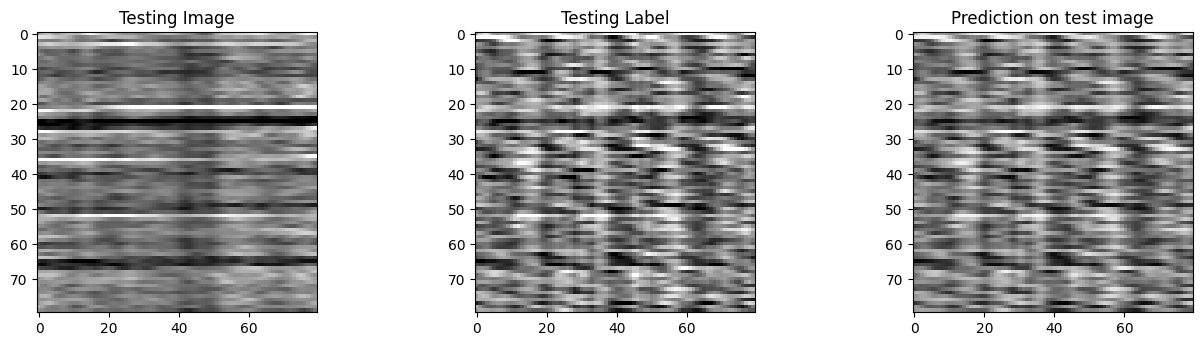

In [ ]:
import random
test_img_number = random.randint(0, len(test_dataset)-1)
test_img = test_dataset[test_img_number]
ground_truth=test_mask_dataset[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(y_pred[test_img_number,:,:,0], cmap='gray')

plt.show()

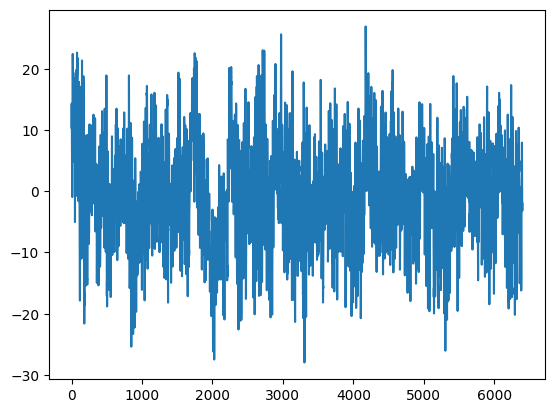

In [ ]:
plt.plot(np.reshape(scaler.inverse_transform(y_pred[test_img_number,:,:,0]),(6400,1)))

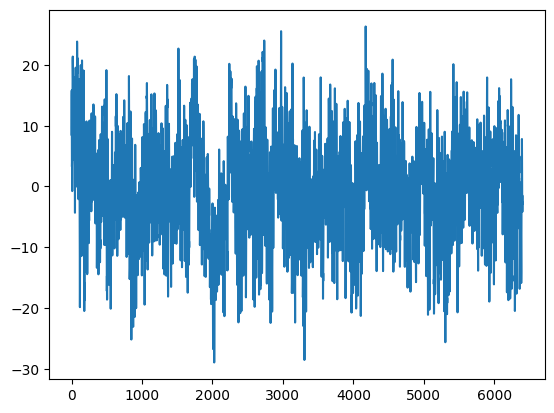

In [ ]:
plt.plot(np.reshape(scaler.inverse_transform(ground_truth[:,:,0]),(6400,1)))

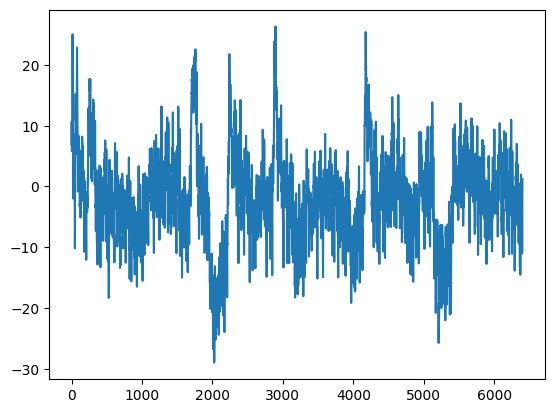

In [ ]:
plt.plot(np.reshape(scaler.inverse_transform(test_img[:,:,0]),(6400,1)))

In [ ]:
truth=(np.reshape(ground_truth[:,:,0],(6400,1)))
pred=(np.reshape(y_pred[test_img_number,:,:,0],(6400,1)))

In [ ]:
scipy.io.savemat('truth.mat', {'truth': truth})
scipy.io.savemat('pred.mat', {'pred': pred})